In [50]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy import stats
import multiprocessing

%matplotlib inline
%config Completer.use_jedi = False

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

sns.set_context("paper")

sns.set(style="whitegrid", color_codes=True, font_scale=1.3)
color_blind = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
divert_color = ['#a6611a','#dfc27d','#f5f5f5','#80cdc1','#018571']

#### Utility Functions

In [51]:
# utility function for printing percentages
def percentage(part, whole):
    percent = 100 * float(part) / float(whole)
    percent = round(percent, 1)
    return f"{part:,} ({str(percent)}%)"

### Motivation and Approach used by the authors to answer RQ3
>Section 3.2.3 
RQ3: What are the Characteristics of the Users who Contributed to Code With Weaknesses?

>**Motivation**. During the creation or revision of a code snippet, users may introduce CWE instances in the code snippet as shown in Section 4.2. In this RQ, we study the users who introduce CWE instances, i.e., by either posting or editing code, during the evolution of $Code_w$. Furthermore, we explore the characteristics when they contribute $Code_w$. A better understanding of such users who participate in the evolution of code snippets can provide insights for Stack Overflow to improve their current mechanism, e.g., code revision, for better code security practices.

>**Approach**. We first identify those users who contributed $Version_w$. We examine whether the majority of $Version_w$ were contributed by a small group of the users. Next, we examine whether the activity level of a user on Stack Overflow is associated with the likelihood of their involvement in $Version_w$. To do so, we estimate a user’s activity level through two aspects: the number of code versions that were performed by a user and the reputation of the user. It is challenging to measure a user’s activity level on Stack Overflow. In our study, we use both code revision count in C/C++ posts and reputation points as proxies to measure user activity level. The reputation of a user is a common proxy to measure user activity level in prior studies [5], [29], [30], [31]. However, the reputation of a user is not directly related to his/her activity level on Stack Overflow. For example, a user can have a high reputation even if he/she only asks popular questions and never posts any answer. Therefore, reputation can be biased to the types of activities, i.e., asking or answering, or activities in other programming languages. To alleviate bias from reputation points, we also use the number of code revisions made by a user to measure their activity level in maintaining code snippets on Stack Overflow. Furthermore, we only consider the number of C/C++ code revisions, which directly reflects a user’s activity level with regard to C/C++.

>We analyze the correlation between the number of contributed code versions by a user, including both $Version_w$ and code versions without weaknesses, and the code weakness density, i.e., the proportion of $Version_w$, in all the posted code versions by the same user. Second, we study the characteristics of those involved users who contribute any code version, including both $Version_w$ and code versions without weaknesses, using their gained reputation points, as a proxy for user activity/involvement on Stack Overflow [29], [31]. We examine whether the number of CWE instances within the contributed $Version_w$ by a user is correlated with the gained reputation points by the same user. More specifically, we wish to examine whether or not active users in terms of reputation points are more likely to post secure code snippets. Finally, we wish to understand if users repeatedly contribute the same type of weaknesses, i.e., the same CWE type. We calculate the number of CWE instances by a user across different CWE types. For users who repeatedly post the same CWE type, we measure the timespan of the CWE instances between the first and last CWE instance.

>**Measurement of User Reputation**. The Stack Overflow plat- form only provides the current reputation points of a user. In order to measure the reputation points of a user when he/she posts or edits a code version, we first crawled 22 the information of all users who posted/edited C/C++ code snippets, including Codew and code snippets without weak- nesses, about their daily gain of reputation points. To calcu- late the reputation points when a user posted/edited a code snippet, we sum up the daily gain of reputation points before the date of the specific code version.

#### Schema Description

1. **UserId**: Identifies the user that contributed C/C++ code snippets. If the CWE = 0, then the code version (identified by `PostBlockVersionId` does not contain a security weakness
2. **Reputation**: The reputation points of the user that contributed C/C++ code versions
3. **PostBlockVersionId**: The code version with (CWE != 0) or without (CWE = 0) security weaknesses.
4. **CWE**: The actual CWE type detected for a code version. The type is a number $>= 0$, where CWE = 0 means no security weaknesses detected for a code version.

In [52]:
# data collected using Cppcheck 2.13 on SOTorrent22
# Only C/C++ code snippets are considered
df_user_cwe = pd.read_feather("data/feather_files/UserCWEData.feather")

In [53]:
# Remove rows with UserId = -1
df_user_cwe = df_user_cwe[df_user_cwe['UserId'] != -1]

In [54]:
df_user_cwe.columns

Index(['RootPostBlockVersionId', 'PostBlockVersionId', 'UserId',
       'PostHistoryId', 'PostHistoryDate', 'CWE', 'CWE_Instances_Added',
       'CWE_Types_Added', 'Num_CWE_Types_Added', 'Num_CWE_Instances_Added',
       'Num_CWE'],
      dtype='object')

# Data Preparation

The user_data_frame contains the CWE instances detected in every C/C++ code snippets. The original approach used by the authors to answer RQ3 is as follows: They counted each such instance. However, a post edit may not necessarily introduce a new CWE instance but simply does not remove an existing one. Thus, a more fair approach would be to count the number of CWE instances added and removed in each version.

Thus, the UserCWEData.feather file includes columns for the added CWE instances and the added CWE types. The added CWE instances are calculated by taking the difference between the number of CWE instances in the current version and the previous version. The added CWE types are calculated by taking the difference between the number of unique CWE types in the current version and the previous version. If the previous version is not available, the current version is considered the first version, and the added CWE instances and types are set to the number of CWE instances and types in the current version, respectively.

In [55]:
print(f"Total number of C/C++ code snippets: {df_user_cwe['PostBlockVersionId'].unique().size:,} from {df_user_cwe['UserId'].unique().size:,} users")
print(f"Total number of code snippets with weaknesses: {percentage(df_user_cwe[df_user_cwe['Num_CWE'] != 0]['PostBlockVersionId'].unique().size, df_user_cwe['PostBlockVersionId'].unique().size)}")
print(f"Total number of users who contributed code snippets with weaknesses: {percentage(df_user_cwe[df_user_cwe['Num_CWE'] != 0]['UserId'].unique().size, df_user_cwe['UserId'].unique().size)}")

Total number of C/C++ code snippets: 495,330 from 75,779 users
Total number of code snippets with weaknesses: 37,333 (7.5%)
Total number of users who contributed code snippets with weaknesses: 12,845 (17.0%)


In [56]:
# Find user IDs with zero CWE instances
users_without_weaknesses = df_user_cwe.groupby('UserId')['Num_CWE'].sum()
users_without_weaknesses = users_without_weaknesses[users_without_weaknesses == 0].index
print(f"Total number of users who only contributed code snippets without weaknesses: {percentage(users_without_weaknesses.size, df_user_cwe['UserId'].unique().size)}")

Total number of users who only contributed code snippets without weaknesses: 62,934 (83.0%)


### Author Claim A: A small number of users contribute the majority of the code versions with weaknesses.

>The majority of the C/C++ $Version_w$ were contributed by a small number of users. 72.4 percent (i.e., 10,652) of $Version_w$ were posted by 36 percent (i.e., 2,292) of users, as shown in Fig. 9.

The authors reported that $36$% (i.e., 2,292) of the users contributed 72.4% (i.e, 10,652) of the code versions with weaknesses (see Fig. 9).

In [57]:
# Find the number of users who contributed the majority of the code versions with weaknesses.
df_accumulative_versions = df_user_cwe.loc[df_user_cwe['Num_CWE']>0].groupby('UserId')['Num_CWE'].sum().sort_values(ascending=False)
# Add a column to the dataframe to keep track of the cumulative sum of versions
df_accumulative_versions = df_accumulative_versions.reset_index()
df_accumulative_versions['cumulative_sum'] = df_accumulative_versions['Num_CWE'].cumsum()
df_accumulative_versions['cumulative_percentage'] = df_accumulative_versions['cumulative_sum'] / df_accumulative_versions['Num_CWE'].sum()
# Add a column to the dataframe to keep track of the number of users
df_accumulative_versions['user_count'] = df_accumulative_versions.index + 1
df_accumulative_versions['user_count_cumulative_percentage'] = df_accumulative_versions['user_count'] / len(df_accumulative_versions)
df_accumulative_versions

,UserId,Num_CWE,cumulative_sum,cumulative_percentage,user_count,user_count_cumulative_percentage
0,2877241,601,601,0.012420,1,0.000078
1,65863,374,975,0.020150,2,0.000156
2,15168,368,1343,0.027755,3,0.000234
3,3422102,362,1705,0.035236,4,0.000311
4,4593267,334,2039,0.042139,5,0.000389
...,...,...,...,...,...,...
12840,2138913,1,48384,0.999917,12841,0.999689
12841,2137996,1,48385,0.999938,12842,0.999766
12842,2137370,1,48386,0.999959,12843,0.999844
12843,2136640,1,48387,0.999979,12844,0.999922


In [58]:
print(f"72.4% corresponds to {df_accumulative_versions[df_accumulative_versions['cumulative_percentage'] > 0.724]['cumulative_sum'].iloc[0]:,} Versions with weaknesses; these were contributed by {df_accumulative_versions[df_accumulative_versions['cumulative_percentage'] > 0.724]['user_count_cumulative_percentage'].iloc[0]*100:.1f}% ({df_accumulative_versions[df_accumulative_versions['cumulative_percentage'] > 0.724]['user_count'].iloc[0]:,}) of users")
print(f"36% of users corresponds to {df_accumulative_versions[df_accumulative_versions['user_count_cumulative_percentage'] > 0.36]['user_count'].iloc[0]:,} Users, which contributed {df_accumulative_versions[df_accumulative_versions['user_count_cumulative_percentage'] > 0.36]['cumulative_percentage'].iloc[0]*100:.1f}% ({df_accumulative_versions[df_accumulative_versions['user_count_cumulative_percentage'] > 0.36]['cumulative_sum'].iloc[0]:,}) of the versions with weaknesses")

72.4% corresponds to 35,034 Versions with weaknesses; these were contributed by 25.0% (3,205) of users
36% of users corresponds to 4,625 Users, which contributed 79.5% (38,481) of the versions with weaknesses


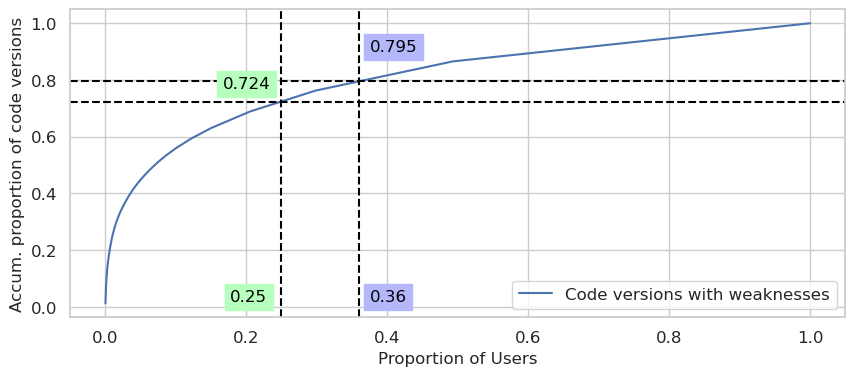

In [59]:
# Plot the cumulative percentage of code versions with weaknesses contributed by users
plt.figure(figsize=(10, 4))
sns.lineplot(data=df_accumulative_versions, x='user_count_cumulative_percentage', y='cumulative_percentage')
plt.xlabel('Proportion of Users', fontsize=12)
plt.ylabel('Accum. proportion of code versions', fontsize=12)
# Format y-axis as float
plt.gca().yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Code versions with weaknesses'], loc='lower right', fontsize=12)

anno_x = df_accumulative_versions[df_accumulative_versions['cumulative_percentage'] > 0.724]['user_count_cumulative_percentage'].iloc[0]
anno_y = df_accumulative_versions[df_accumulative_versions['user_count_cumulative_percentage'] > 0.36]['cumulative_percentage'].iloc[0]

plt.axvline(x=anno_x, color='black', linestyle='--')
plt.text(anno_x-0.02, 0.02, f'{round(anno_x, 2)}', fontsize=12, color='black', ha='right', backgroundcolor='#B6FFBC')
plt.axhline(y=0.724, color='black', linestyle='--')
plt.text(anno_x-0.015, 0.77, '0.724', fontsize=12, color='black', ha='right', backgroundcolor='#B6FFBC')

plt.axvline(x=0.36, color='black', linestyle='--')
plt.text(0.36+0.015, 0.02, f'{round(0.36, 2)}', fontsize=12, color='black', ha='left', backgroundcolor='#B4B8FB')
plt.axhline(y=anno_y, color='black', linestyle='--')
plt.text(0.36+0.015, 0.9, f'{round(anno_y, 3)}', fontsize=12, color='black', ha='left', backgroundcolor='#B4B8FB')
# Save the plot
plt.savefig('plots/Zhang_RQ3_AccumulativeProportion.pdf', bbox_inches='tight')
plt.show()

### Replicate Claim A  (*SOTorrent22*)
The results of the replication are shown below. While we also found a small number of users that contributed the majority of $Version_w$ with weaknesses, the numbers are markedly different. The authors reported that 36% of users contributed $Version_w$ while we found 18.9% users contributing $Version_w$.

In [60]:
df_with_weaknesses = df_user_cwe[df_user_cwe['Num_CWE'] > 0]
users_with_weaknesses = df_with_weaknesses['UserId'].unique()
users = df_user_cwe['UserId'].unique()
weak_versions = df_user_cwe[df_user_cwe['Num_CWE'] != 0]['PostBlockVersionId']
print(f"Versions with weaknesses: {weak_versions.unique().size:,}")
print(f"A total of {users.size:,} users contributed C/C++ code snippets")
print(f"{percentage(users_with_weaknesses.size, users.size)} of users contributed code versions with weaknesses")

Versions with weaknesses: 37,333
A total of 75,779 users contributed C/C++ code snippets
12,845 (17.0%) of users contributed code versions with weaknesses


### Author Claim B:
>$64.0$ percent (i.e., $4,070$) of the users who contribute $Version_w$ have contributed only one $Version_w$

In [61]:
# Find the number of users who contributed a single version with weaknesses.
single_version_users = df_with_weaknesses.loc[df_with_weaknesses['Num_CWE'] == 1, 'UserId'].nunique()
print(f"{percentage(single_version_users, users_with_weaknesses.size)} of users contributed only one version with weaknesses")

11,077 (86.2%) of users contributed only one version with weaknesses


### Author Claim C: 

>Among all the 85,165 users who posted C/C++ code snippets, only 7.5 percent (i.e., 6,361) of them posted code snippets that have weaknesses.

In [62]:
# Find the number of users who contributed code snippets with weaknesses
print(f"{percentage(users_with_weaknesses.size, users.size)} of {users.size:,} users contributed code snippets with weaknesses")

12,845 (17.0%) of 75,779 users contributed code snippets with weaknesses


### Author Claim D: more active users are less likely to introduce $Code_w$ (see Figure 10)

Summary: Figure 10 shows that the weakness density of a user’s code drops when the number of contributed code revisions by the user increases.

> We analyze the correlation between the number of contributed code versions by a user, including both Version w and code versions without weaknesses, and the code weakness density, i.e., the proportion of Version w , in all the posted code versions by the same user.
      
>More active users are less likely to introduce Codew. Fig. 10 illustrates the relationship between the number of code revisions contributed by a user and the weakness density of a user’s code. The figure shows that the weakness density of a user’s code drops when the number of contributed code revisions by the user increases. In particular, 15.1 percent (i.e., 958) of the users contribute only one code version ever and it is a Versionw, as shown by the top left point in Fig. 10

>Fig. 10. As the number of code revisions increases for a user, the density of contributed $Version_w$ by that user drops.

,UserId,count,sum,weakness_density
66069,10458067,1,1,1.0
50978,5357130,2,2,1.0
23220,1423110,1,1,1.0
39714,3329069,2,2,1.0
7553,289691,1,1,1.0
...,...,...,...,...
28068,1872540,7,0,0.0
28069,1872824,4,0,0.0
28070,1872867,1,0,0.0
28071,1872949,2,0,0.0


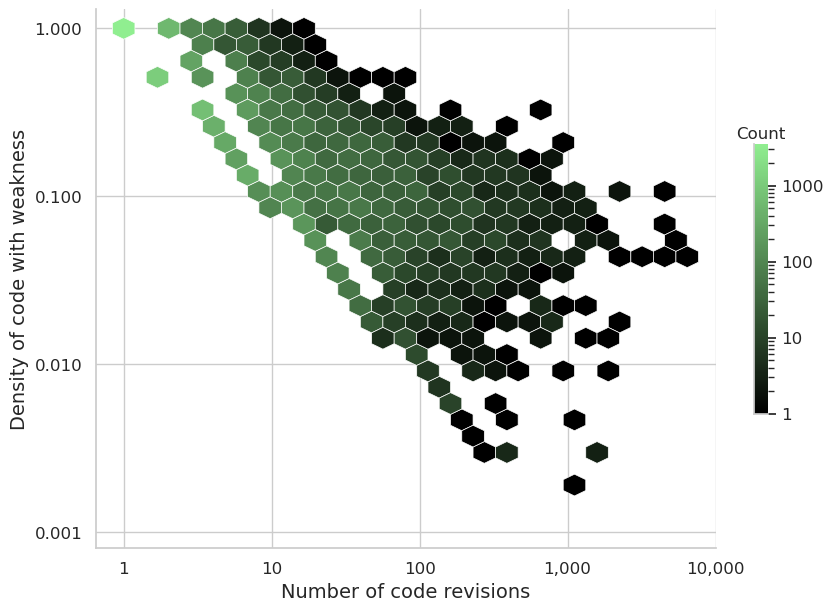

In [63]:
# Compute the ratio of all versions with weaknesses to all versions contributed by a user
user_data_frame_normed = df_user_cwe[['UserId', 'Num_CWE']].copy()
user_data_frame_normed['CWE'] = user_data_frame_normed['Num_CWE'].apply(lambda x: 1 if x > 0 else 0)
df_weakness_density = user_data_frame_normed.groupby('UserId')['CWE'].agg(['count', 'sum'])
df_weakness_density['weakness_density'] = df_weakness_density['sum'] / df_weakness_density['count']
df_weakness_density = df_weakness_density.reset_index()
display(df_weakness_density.sort_values(by='weakness_density', ascending=False))

# Remove users with 0 density
df_weakness_density = df_weakness_density[df_weakness_density['weakness_density'] != 0]

from matplotlib.colors import LinearSegmentedColormap
# Plot the relationship between the number of code revisions contributed by a user and the weakness density
plt.figure(figsize=(10, 7))
# sns.scatterplot(data=df_weakness_density, x='count', y='weakness_density')
# hb = sns.jointplot(data=df_weakness_density, x='count', y='weakness_density', kind='hex', gridsize=50, cmap='Greens', bins='log')

hb = plt.hexbin(df_weakness_density['count'], df_weakness_density['weakness_density'], gridsize=25, cmap=LinearSegmentedColormap.from_list('black_to_green', ['black', 'lightgreen']), bins='log', xscale='log', yscale='log', linewidths=0.5, edgecolors='white', mincnt=0.001, reduce_C_function=np.sum)
# hb = df_weakness_density.plot.hexbin(x='count', y='weakness_density', gridsize=20, cmap='Greens', bins='log', sharex=False)
cb = plt.colorbar(hb, label=None, shrink=0.5)
# colorbar smaller
cb.ax.yaxis.set_label_position('right')
cb.ax.yaxis.set_ticks_position('right')
cb.ax.yaxis.set_tick_params(labelsize=12)
cb.outline.set_visible(False)
# title of the colorbar on top
cb.ax.xaxis.set_label_position('top')
cb.ax.xaxis.set_label_text('Count',size=12)
# cb log scale
# cb.ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
cb.ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

sns.despine()
# plt.grid(False)
plt.xlabel('Number of code revisions', fontsize=14)
plt.ylabel('Density of code with weakness', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# y-asxis with ticks at 0.1, 0.01, 0.001, 0.0001
plt.gca().set_yticks([1.0, 0.1, 0.01, 0.001])
plt.gca().set_yticklabels(['1.000', '0.100', '0.010', '0.001'])
plt.gca().set_xticks([1, 10, 100, 1000, 10000])
plt.gca().set_xticklabels(['1', '10', '100', '1,000', '10,000'])
# Y-axis limits
plt.gca().set_ylim([0.0008, 1.3])
# Save the plot
plt.savefig('plots/Zhang_RQ3_WeaknessDensity.pdf', bbox_inches='tight')
plt.show()


In [64]:
# Calculate the Pearson correlation coefficient and the p-value
correlation_coefficient, p_value = pearsonr(df_weakness_density['count'], df_weakness_density['sum'])

print(f'Pearson correlation coefficient: {correlation_coefficient}')
print(f'P-value: {p_value}')

Pearson correlation coefficient: 0.8438496791437603
P-value: 0.0


In [65]:
# Calculate the Pearson correlation coefficient and the p-value
correlation_coefficient, p_value = pearsonr(df_weakness_density['count'], df_weakness_density['weakness_density'])

print(f'Pearson correlation coefficient: {correlation_coefficient}')
print(f'P-value: {p_value}')

Pearson correlation coefficient: -0.18950494662800904
P-value: 3.7493561420033015e-104


In [66]:
import statsmodels.api as sm
# Define the dependent and independent variables
X = df_weakness_density['count']
y = df_weakness_density['weakness_density']

# Add a constant to the independent variable matrix (intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())
#
# # Extracting specific statistics
# r_squared = model.rsquared
# adj_r_squared = model.rsquared_adj
# p_value = model.pvalues['count']
# coef = model.params['count']
#
# print(f'R-squared: {r_squared}')
# print(f'Adjusted R-squared: {adj_r_squared}')
# print(f'Coefficient for revisions: {coef}')
# print(f'P-value for revisions: {p_value}')

                            OLS Regression Results                            
Dep. Variable:       weakness_density   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     478.4
Date:                Sun, 19 Jan 2025   Prob (F-statistic):          3.75e-104
Time:                        17:53:02   Log-Likelihood:                -5587.8
No. Observations:               12845   AIC:                         1.118e+04
Df Residuals:                   12843   BIC:                         1.119e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5191      0.003    154.802      0.0

In [67]:
# How many with weakness density = 1
print(f"Number of users with weakness density = 1: {df_weakness_density[df_weakness_density['weakness_density'] == 1].shape[0]:,}")

Number of users with weakness density = 1: 4,267


> In Fig. 11, we compare the reputation of the contributor for a code version with different numbers of CWE instances in the code version, which shows that **users with higher reputation tend to introduce fewer CWE instances in their contributed code versions**.

In [68]:
%%script false --no-raise-error
df_reputation_by_day = pd.read_feather("data/feather_files/ReputationByDay.feather")

In [69]:
%%script false --no-raise-error
df_reputation_by_day

In [70]:
%%script false --no-raise-error
df_cwe_with_reputation = df_user_cwe.sort_values(by=['RootPostBlockVersionId', 'PostBlockVersionId'])

In [71]:
%%script false --no-raise-error
# Filter out UserIds from df_reputation_by_day that are not in df_cwe_count
user_ids = frozenset(df_cwe_with_reputation['UserId'].unique())
df_reputation_by_day = df_reputation_by_day[df_reputation_by_day['RepUserId'].isin(user_ids)]

In [72]:
%%script false --no-raise-error
# Get max CreationDate for df_cwe_count
max_date = df_cwe_with_reputation['CreationDate'].max()
# Filter out CreationDate from df_reputation_by_day that are after max_date
df_reputation_by_day = df_reputation_by_day[df_reputation_by_day['CreationDate'] <= max_date]

In [73]:
%%script false --no-raise-error
# Save the dataframe to a feather file
df_reputation_by_day.to_feather("data/feather_files/df_reputation_by_day_filtered.feather")

In [74]:
%%script false --no-raise-error
def get_reputation_at_time(user_id, time):
    user_reputation = df_reputation_by_day[(df_reputation_by_day['RepUserId'] == user_id) & (df_reputation_by_day['CreationDate'] <= time)]
    if user_reputation.empty:
        return 0
    return user_reputation['ReputationChange'].iloc[-1]

In [75]:
%%script false --no-raise-error
# Get number of CPU cores
n_cores = multiprocessing.cpu_count()

# This might run for several hours, depending on the available CPU cores (ca. 3h with 64 cores)
ddf = dd.from_pandas(df_cwe_with_reputation, npartitions=n_cores)
result = ddf.apply(lambda x: get_reputation_at_time(x['UserId'], x['CreationDate']), meta=('Reputation', 'int64'), axis=1).compute()

In [76]:
%%script false --no-raise-error
df_cwe_with_reputation['Reputation'] = result

In [77]:
%%script false --no-raise-error

# Save the dataframe to a feather file
df_cwe_with_reputation.to_feather("data/feather_files/df_cwe_count_with_reputation.feather")

In [78]:
df_cwe_with_reputation = pd.read_feather("data/feather_files/df_cwe_count_with_reputation.feather")

In [79]:
df_cwe_with_reputation.head()

,PostId,PostTypeId,PostVersionId,RootPostBlockVersionId,PostBlockVersionId,UserId,CreationDate,CWE,Num_CWE,CWE_Instances_Added,Num_CWE_Instances_Added,CWE_Types_Added,Num_CWE_Types_Added,Reputation,CWE_binned
0,45760385,2,39797126,138299634,138299634,335858,2017-08-18 15:40:39,[],0,[],0,[],0,658179,0
1,21201235,2,39797345,138300281,138300281,296460,2014-01-18 07:14:14,[],0,[],0,[],0,4482,0
2,33254621,2,39798659,138303943,138303943,5389107,2015-10-21 08:50:27,[],0,[],0,[],0,1376,0
3,21201624,2,39798914,138304597,138304597,1619294,2014-01-18 08:01:30,[],0,[],0,[],0,7538,0
4,33254714,2,39799012,138304847,138304847,5439654,2015-10-21 08:44:49,[],0,[],0,[],0,123,0


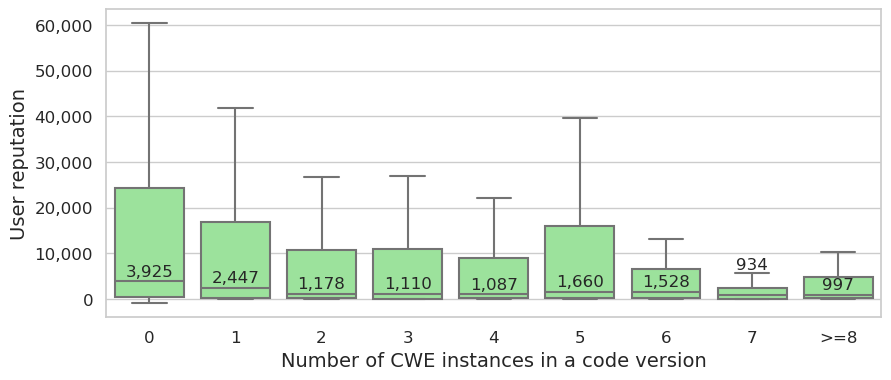

In [80]:
# Combine the CWE instances >8 into a single category
df_cwe_with_reputation['CWE_binned'] = df_cwe_with_reputation['Num_CWE'].apply(lambda x: 8 if x > 8 else x)

# Plot CVE instances by reputation
plt.figure(figsize=(10, 4))
sns.boxplot(data=df_cwe_with_reputation, x='CWE_binned', y='Reputation', showfliers=False, color='lightgreen', linewidth=1.5)
plt.xlabel('Number of CWE instances in a code version', fontsize=14)
plt.ylabel('User reputation', fontsize=14)
plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Annotate the mean reputation for each category
for i in range(9):
    mean_reputation = df_cwe_with_reputation[df_cwe_with_reputation['CWE_binned'] == i]['Reputation'].median()
    if i == 6:
        plt.text(i, mean_reputation+700, f'{mean_reputation:,.0f}', ha='center', va='bottom', fontsize=12)
    elif i == 7:
        plt.text(i, mean_reputation+5000, f'{mean_reputation:,.0f}', ha='center', va='bottom', fontsize=12)
    elif i == 8:
        plt.text(i, mean_reputation+500, f'{mean_reputation:,.0f}', ha='center', va='bottom', fontsize=12)
    else:
        plt.text(i, mean_reputation+500, f'{mean_reputation:,.0f}', ha='center', va='bottom', fontsize=12)

# Rename the x-axis label for 8+ CWE instances
plt.xticks(np.arange(9), [str(i) if i < 8 else '>=8' for i in range(9)])

# Save the plot
plt.savefig('plots/Zhang_RQ3_CWE_vs_Reputation.pdf', bbox_inches='tight')
plt.show()


In [81]:
# Calculate the Pearson correlation coefficient and the p-value
correlation_coefficient, p_value = pearsonr(df_cwe_with_reputation['Reputation'], df_cwe_with_reputation['Num_CWE'])

print(f'Pearson correlation coefficient: {correlation_coefficient}')
print(f'P-value: {p_value}')

Pearson correlation coefficient: -0.022654750688841187
P-value: 3.0205043151749776e-57


In [82]:
X =df_cwe_with_reputation['Reputation']
y = df_cwe_with_reputation['Num_CWE']

# Add a constant to the independent variable matrix (intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Num_CWE   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     254.4
Date:                Sun, 19 Jan 2025   Prob (F-statistic):           3.02e-57
Time:                        17:53:05   Log-Likelihood:            -3.8128e+05
No. Observations:              495330   AIC:                         7.626e+05
Df Residuals:                  495328   BIC:                         7.626e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1023      0.001    128.372      0.0

### Author Claim F: 
>In total, 78.0 percent of users contribute code with only one CWE type.

In [83]:
df_cwe_exploded = df_with_weaknesses[['UserId', 'PostBlockVersionId','CWE']].explode('CWE')
df_cwe_exploded.head()

,UserId,PostBlockVersionId,CWE
11,691711,138306781,457
12,5424617,138307273,457
12,5424617,138307273,457
12,5424617,138307273,457
37,20322,138318338,758


In [84]:
# Find the number of unique CWE types for each user
df_cwe_per_user_count = df_cwe_exploded.groupby('UserId')['CWE'].nunique().reset_index()
# Remove deleted users with UserId = -1
df_cwe_per_user_count = df_cwe_per_user_count[df_cwe_per_user_count['UserId'] != -1]
df_cwe_per_user_count

,UserId,CWE
0,13,4
1,42,1
2,95,1
3,102,2
4,116,1
...,...,...
12840,19080653,2
12841,19116804,2
12842,19119598,1
12843,19148257,1


In [85]:
df_cwe_user_count = df_cwe_per_user_count['CWE'].value_counts().reset_index()
df_cwe_user_count.columns = ['CWE', 'Users']

sum_5_9 = df_cwe_user_count[(df_cwe_user_count['CWE'] >= 5) & (df_cwe_user_count['CWE'] < 10)]['Users'].sum()
sum_10_plus = df_cwe_user_count[df_cwe_user_count['CWE'] >= 10]['Users'].sum()

df_cwe_user_count = df_cwe_user_count[df_cwe_user_count['CWE'] < 5]

# Create a new DataFrame for the new row
new_row_5_9 = pd.DataFrame({'CWE': ['[5-10)'], 'Users': [sum_5_9]})
new_row_10_plus = pd.DataFrame({'CWE': ['>=10'], 'Users': [sum_10_plus]})

# Append the new row to the original DataFrame using concat
df_cwe_user_count = pd.concat([df_cwe_user_count, new_row_5_9], ignore_index=True)
df_cwe_user_count = pd.concat([df_cwe_user_count, new_row_10_plus], ignore_index=True)

# Reset the index of the DataFrame
df_cwe_user_count = df_cwe_user_count.reset_index(drop=True)

# Calculate the percentage of users
df_cwe_user_count['Percentage'] = df_cwe_user_count['Users'] / df_cwe_per_user_count.shape[0] * 100
df_cwe_user_count

,CWE,Users,Percentage
0,1,9582,74.597120
1,2,1902,14.807318
2,3,641,4.990269
3,4,297,2.312184
4,[5-10),366,2.849358
5,>=10,57,0.443752


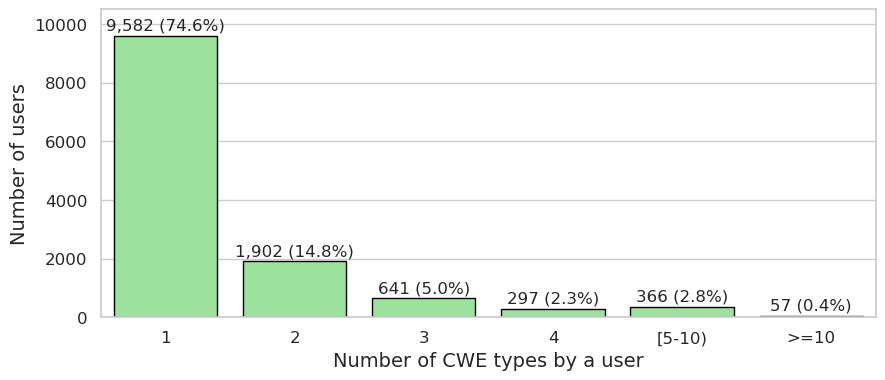

In [86]:
# Plot the distribution of the number of CWE instances contributed by different users
plt.figure(figsize=(10, 4))
sns.barplot(data=df_cwe_user_count, x='CWE', y='Users', color='lightgreen', edgecolor='black')
plt.xlabel('Number of CWE types by a user', fontsize=14)
plt.ylabel('Number of users', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Annote the number and percentage of users
for i in range(df_cwe_user_count.shape[0]):
    plt.text(i, df_cwe_user_count['Users'][i]+100, f"{df_cwe_user_count['Users'][i]:,} ({df_cwe_user_count['Percentage'][i]:.1f}%)", ha='center', va='bottom', fontsize=12)
# y-lim
plt.gca().set_ylim([0, 10500])
# Save the plot
plt.savefig('plots/Zhang_RQ3_CWE_Types_Per_User.pdf', bbox_inches='tight')
plt.show()

 > Furthermore, 42.2 percent (i.e., 2,686) of the users contribute only one CWE instance in all their Versionw, as shown in Fig. 12. 81.8 percent (i.e., 5,206) of the users contribute less than five CWE instances in all their Versionw .
 
**Note:** This does not make sense. Would this mean that there are 1,472 users who contributed 2 CWE instances in all their versions? What if a user contributed 2 CWE instances in one version and 1 CWE instance in another version? How to count this?

We assume they counted the number of CWE instances in all versions contributed by a user.

In [87]:
# Find the number of CWE instances for each user
# df_cwe_per_user = df_cwe_exploded.groupby(['UserId', 'PostBlockVersionId'])['CWE'].count().reset_index()
df_cwe_per_user = df_cwe_exploded.groupby(['UserId'])['CWE'].count().reset_index()
# Remove deleted users with UserId = -1
df_cwe_per_user = df_cwe_per_user[df_cwe_per_user['UserId'] != -1]
df_cwe_per_user

,UserId,CWE
0,13,5
1,42,1
2,95,1
3,102,6
4,116,1
...,...,...
12840,19080653,2
12841,19116804,17
12842,19119598,1
12843,19148257,1


In [88]:
df_cwe_per_user_count = df_cwe_per_user['CWE'].value_counts().reset_index()
df_cwe_per_user_count.columns = ['CWE', 'Users']

sum_5_9 = df_cwe_per_user_count[(df_cwe_per_user_count['CWE'] >= 5) & (df_cwe_per_user_count['CWE'] < 10)]['Users'].sum()
sum_10_plus = df_cwe_per_user_count[df_cwe_per_user_count['CWE'] >= 10]['Users'].sum()

df_cwe_per_user_count = df_cwe_per_user_count[df_cwe_per_user_count['CWE'] < 5]

# Create a new DataFrame for the new row
new_row_5_9 = pd.DataFrame({'CWE': ['[5-10)'], 'Users': [sum_5_9]})
new_row_10_plus = pd.DataFrame({'CWE': ['>=10'], 'Users': [sum_10_plus]})

# Append the new row to the original DataFrame using concat
df_cwe_per_user_count = pd.concat([df_cwe_per_user_count, new_row_5_9], ignore_index=True)
df_cwe_per_user_count = pd.concat([df_cwe_per_user_count, new_row_10_plus], ignore_index=True)

# Reset the index of the DataFrame
df_cwe_per_user_count = df_cwe_per_user_count.reset_index(drop=True)

# Calculate the percentage of users
df_cwe_per_user_count['Percentage'] = df_cwe_per_user_count['Users'] / df_cwe_per_user_count["Users"].sum() * 100

df_cwe_per_user_count

,CWE,Users,Percentage
0,1,6533,50.860257
1,2,2500,19.462826
2,3,1189,9.256520
3,4,716,5.574153
4,[5-10),1112,8.657065
5,>=10,795,6.189179


In [89]:
df_cwe_per_user_count = df_cwe_per_user_count.assign(Original=[2686, 1472, 578, 470, 690, 465])
df_cwe_per_user_count['Percentage_Original'] = df_cwe_per_user_count['Original'] / df_cwe_per_user_count["Original"].sum() * 100
df_cwe_per_user_count

,CWE,Users,Percentage,Original,Percentage_Original
0,1,6533,50.860257,2686,42.226065
1,2,2500,19.462826,1472,23.141016
2,3,1189,9.256520,578,9.086622
3,4,716,5.574153,470,7.388775
4,[5-10),1112,8.657065,690,10.847351
5,>=10,795,6.189179,465,7.310171


In [90]:
# Pivot the DataFrame to make "Original" and "Users" as a single column
df_cwe_per_user_count = df_cwe_per_user_count.melt(id_vars=['CWE'], value_vars=['Original', 'Users'], var_name='Type', value_name='Count')
df_cwe_per_user_count

,CWE,Type,Count
0,1,Original,2686
1,2,Original,1472
2,3,Original,578
3,4,Original,470
4,[5-10),Original,690
5,>=10,Original,465
6,1,Users,6533
7,2,Users,2500
8,3,Users,1189
9,4,Users,716


In [91]:
# Column with CumSum of Count by Type
df_cwe_per_user_count['CumSum'] = df_cwe_per_user_count.groupby('Type')['Count'].cumsum()
df_cwe_per_user_count

,CWE,Type,Count,CumSum
0,1,Original,2686,2686
1,2,Original,1472,4158
2,3,Original,578,4736
3,4,Original,470,5206
4,[5-10),Original,690,5896
5,>=10,Original,465,6361
6,1,Users,6533,6533
7,2,Users,2500,9033
8,3,Users,1189,10222
9,4,Users,716,10938


In [92]:
# Percentage of the CumSum by Type
df_cwe_per_user_count['CumSum_Percentage'] = df_cwe_per_user_count.groupby('Type')['Count'].cumsum() / df_cwe_per_user_count.groupby('Type')['Count'].transform('sum') * 100

In [93]:
df_cwe_per_user_count

,CWE,Type,Count,CumSum,CumSum_Percentage
0,1,Original,2686,2686,42.226065
1,2,Original,1472,4158,65.367081
2,3,Original,578,4736,74.453702
3,4,Original,470,5206,81.842478
4,[5-10),Original,690,5896,92.689829
5,>=10,Original,465,6361,100.000000
6,1,Users,6533,6533,50.860257
7,2,Users,2500,9033,70.323083
8,3,Users,1189,10222,79.579603
9,4,Users,716,10938,85.153756


In [94]:
# Save the data frame to a csv file
df_cwe_per_user_count.to_csv('intermediates/Zhang_RQ3_CWE_Types_Per_User.csv', index=False)

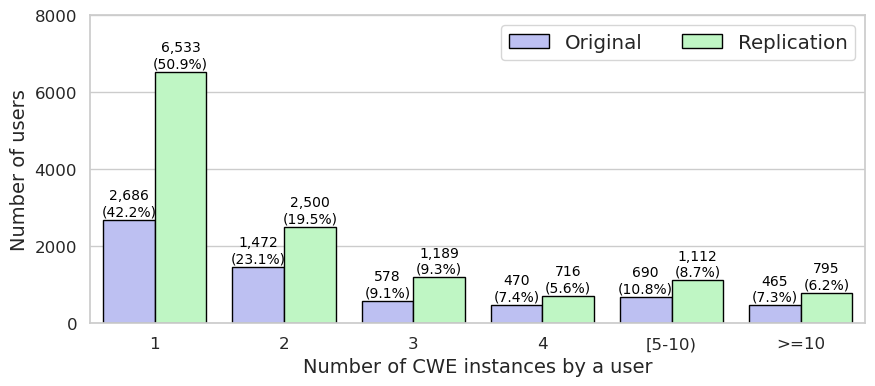

In [95]:
# Plot the distribution of the number of CWE instances contributed by different users
plt.figure(figsize=(10, 4))
ax = sns.barplot(data=df_cwe_per_user_count, x='CWE', y='Count', hue='Type', palette=['#B4B8FB', '#B6FFBC'], edgecolor='black')
plt.xlabel('Number of CWE instances by a user', fontsize=14)
plt.ylabel('Number of users', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.legend(title=None, ncol=2)
new_labels = [ 'Original', 'Replication']
for t, l in zip(ax.get_legend().texts, new_labels): t.set_text(l)

# Annotate the boxes with the value and percentage
for i,p in enumerate(ax.patches):
    height = p.get_height()
    if height == 0:
        continue
    t = 'Original' if i < 6 else 'Users'
    total = df_cwe_per_user_count[df_cwe_per_user_count['Type'] == t]['Count'].sum()
    percentage = height / total * 100
    ax.annotate(f'{int(height):,}\n({percentage:.1f}%)',
                (p.get_x() + p.get_width() / 2., height+100),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=10, color='black')

plt.gca().set_ylim([0, 8000])
# Save the plot
plt.savefig('plots/Zhang_RQ3_CWE_Instances_Per_User.pdf', bbox_inches='tight')
plt.show()

In [96]:
# Create contingency table for the chi-square test of independence
contingency_table = df_cwe_per_user_count.pivot(index='CWE', columns='Type', values='Count')
contingency_table

Type,Original,Users
CWE,,
1,2686,6533
2,1472,2500
3,578,1189
4,470,716
>=10,465,795
[5-10),690,1112


In [97]:
# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print results
print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p}")

# Interpret the p-value
if p < 0.05:
    print("There is a statistically significant difference between the distributions.")
else:
    print("There is no statistically significant difference between the distributions.")

Chi-square statistic: 146.62267373994675
p-value: 6.986613359310599e-30
There is a statistically significant difference between the distributions.


In [98]:
# Calculate Cramer's V
n = contingency_table.sum().sum()
phi2 = chi2 / n
r, k = contingency_table.shape
phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
rcorr = r - ((r-1)**2)/(n-1)
kcorr = k - ((k-1)**2)/(n-1)
cramer_v = np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

print(f"Cramer's V: {cramer_v}")


Cramer's V: 0.08587343598163878


### Author Claim G:
>**Users Tend to Commit the Same Types of CWE Instances Repeatedly**. For each CWE type, we show the distribution of the number of contributed CWE instances by different users in Fig. 13. The figure suggests that certain Stack Overflow users repeatedly contribute code snippets with specific CWE types. For example, we observe that in CWE-401/775/908 some users contribute code with such CWE types for more than 10 times. In other words, users may not even realize that they are posting code snippets with the same potential security weaknesses repeatedly.
> ...
> Furthermore, we observe that the timespan when users repeatedly post the same CWE type is short for the majority of the CWE types, i.e., a median value of less than one day except for CWE-562 – see Appendix F, available in the online supplemental material.

In [99]:
df_count_cwe_per_user = df_cwe_exploded.groupby(['UserId', 'CWE']).size().reset_index(name='Count').sort_values(by=['CWE'], ascending=True)
df_count_cwe_per_user['CWE'] = df_count_cwe_per_user['CWE'].astype(str)
df_count_cwe_per_user

,UserId,CWE,Count
4145,485343,131,1
2783,257645,131,1
7928,1505939,131,1
2354,198536,190,2
3739,414521,190,6
...,...,...,...
7570,1400793,910,4
3123,311966,910,2
13968,4578558,910,2
10394,2424594,910,1


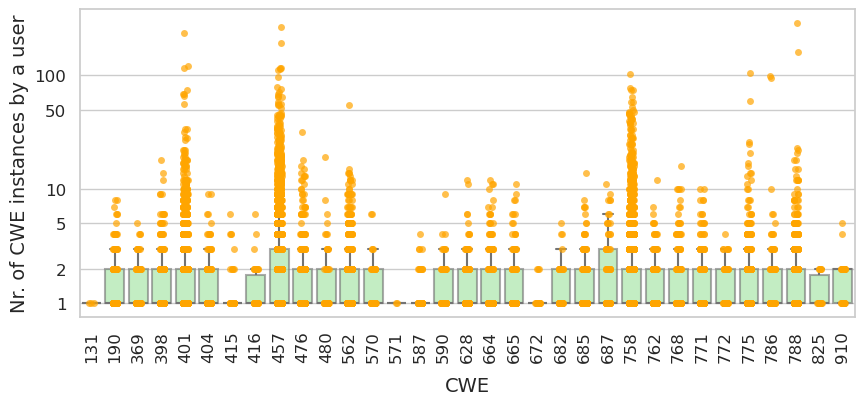

In [100]:
# plot the distribution of the number of CWE instances
plt.figure(figsize=(10, 4))
sns.boxplot(data=df_count_cwe_per_user, x='CWE', y='Count', showfliers=False, color='lightgreen', linewidth=1.5, boxprops=dict(alpha=0.6))
sns.stripplot(x='CWE', y='Count', data=df_count_cwe_per_user, color='orange', jitter=True, alpha=0.7, size=5)
plt.xlabel('CWE', fontsize=14, labelpad=10)
plt.ylabel('Nr. of CWE instances by a user', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().set_yscale('log')
plt.xticks(rotation=90)
# Set y-ticks to 1, 2, 5, 10, 50, 100
plt.gca().set_yticks([1, 2, 5, 10, 50, 100])
plt.gca().set_yticklabels(['1', '2', '5', '10', '50', '100'])

# Save the plot
plt.savefig('plots/Zhang_RQ3_CWE_Type_Frequency.pdf', bbox_inches='tight')
plt.show()

In [101]:
df_count_cwe_per_user.groupby('CWE')['Count'].describe().reset_index()

,CWE,count,mean,std,min,25%,50%,75%,max
0,131,3.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
1,190,149.0,1.885906,1.382957,1.0,1.0,1.0,2.00,8.0
2,369,105.0,1.428571,0.818737,1.0,1.0,1.0,2.00,5.0
3,398,270.0,1.900000,1.930291,1.0,1.0,1.0,2.00,18.0
4,401,2543.0,2.594967,6.936228,1.0,1.0,1.0,2.00,235.0
5,404,135.0,1.681481,1.347479,1.0,1.0,1.0,2.00,9.0
6,415,51.0,1.411765,1.023259,1.0,1.0,1.0,1.00,6.0
7,416,42.0,1.428571,0.966332,1.0,1.0,1.0,1.75,6.0
8,457,6551.0,2.949015,6.873991,1.0,1.0,1.0,3.00,268.0
9,476,571.0,1.963222,2.452434,1.0,1.0,1.0,2.00,32.0


To better understand how users contribute different CWE types, we analyze the users who actively contribute code weaknesses, i.e., at least ﬁve CWE instances, in their Version w . To understand the CWE types that are contributed by each user, we calculate the normalized entropy of the CWE types from his/her posted Code w . More speciﬁcally, we wish to measure whether the CWE types that are contributed by a user are concentrated on a small number of CWE. We count the number of CWE instances for each CWE type, and calculate the normalized entropy of the resulting distribution. Fig. 14 shows the distribution of the normalized entropy for 1,153 users who contributed at least 5 CWE instances. An entropy value of 0 indicates that the user only contributed a single type of CWE in their code snippets. We observe that 37.7 percent of users are likely to introduce a single type of CWE instances in their posted code versions.

In [102]:
# Find users who contributed at least 5 CWE instances
users_with_weaknesses_5 = df_cwe_exploded['UserId'].value_counts()
users_with_weaknesses_5 = users_with_weaknesses_5[users_with_weaknesses_5 >= 5].index
df_cwe_exploded_5 = df_cwe_exploded[df_cwe_exploded['UserId'].isin(users_with_weaknesses_5)]

# Calculate the entropy for each user
from scipy.stats import entropy
# def calculate_entropy(cwe_series):
#     cwe_counts = cwe_series.value_counts()
#     return entropy(cwe_counts, base=2)

def calculate_entropy(cwe_series):
    # Convert to numpy array
    value_counts = np.array(cwe_series.value_counts())

    # Calculate the total number of values
    total_count = np.sum(value_counts)

    # Calculate probabilities
    probabilities = value_counts / total_count

    # Filter out zero probabilities to avoid log(0)
    probabilities = probabilities[probabilities > 0]

    # Calculate the entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))

    # Calculate the maximum entropy
    max_entropy = np.log2(len(probabilities))

    # Handle the case where max_entropy is zero
    if max_entropy == 0:
        return 0.0

    # Calculate the normalized entropy
    normalized_entropy = entropy / max_entropy

    return normalized_entropy

df_entropy = df_cwe_exploded_5.groupby('UserId')['CWE'].apply(calculate_entropy).reset_index(name='Entropy')

# # Normalize the entropy
# max_entropy = np.log2(df_cwe_exploded_5['CWE'].nunique())
# display(max_entropy)
# df_entropy['Entropy'] = df_entropy['Entropy'] / max_entropy
# df_entropy.sort_values(by='Entropy', ascending=False)

df_entropy.sort_values(by='Entropy', ascending=False)

,UserId,Entropy
1337,3826387,1.0
498,618400,1.0
1,102,1.0
495,609139,1.0
958,1892179,1.0
...,...,...
1601,5954246,0.0
1600,5923332,0.0
1599,5922854,0.0
1597,5896591,0.0


In [103]:
# Define the bins
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
bin_labels = ['0', '(0, 0.1]', '(0.1, 0.2]', '(0.2, 0.3]', '(0.3, 0.4]', '(0.4, 0.5]', '(0.5, 0.6]', '(0.6, 0.7]', '(0.7, 0.8]', '(0.8, 0.9]', '(0.9, 1]']

# Convert the list of entropies to a pandas DataFrame
df = pd.DataFrame(df_entropy['Entropy'], columns=['Entropy'])

# Create a new column 'Entropy Bin' with the binned data
df['Entropy Bin'] = pd.cut(df['Entropy'], bins=bins, labels=bin_labels[1:], right=True, include_lowest=True)

# Include the '0' category in the Categorical column
df['Entropy Bin'] = df['Entropy Bin'].cat.add_categories(['0'])

# Add a bin for exactly 0
df.loc[df['Entropy'] == 0, 'Entropy Bin'] = '0'

# Order the categories
df['Entropy Bin'] = pd.Categorical(df['Entropy Bin'], categories=bin_labels, ordered=True)

# Count the number of users in each bin
bin_counts = df['Entropy Bin'].value_counts().sort_index()

# Create a new DataFrame for the plot
plot_data = bin_counts.reset_index()
plot_data.columns = ['Entropy', 'Number of users']

# Calculate the percentage of users in each bin
plot_data['Percentage'] = (plot_data['Number of users'] / plot_data['Number of users'].sum()) * 100

plot_data['Study'] = 'Replication'

# Data in a dictionary of lists
original_data = {
    'Entropy': ['0', '(0, 0.1]', '(0.1, 0.2]', '(0.2, 0.3]', '(0.3, 0.4]', '(0.4, 0.5]', '(0.5, 0.6]', '(0.6, 0.7]', '(0.7, 0.8]', '(0.8, 0.9]', '(0.9, 1]'],
    'Number of users': [435, 0, 0, 8, 17, 31, 65, 64, 135, 165, 233],
    'Percentage': [37.7, 0.0, 0.0, 0.7, 1.5, 2.7, 5.6, 5.6, 11.7, 14.3, 20.2]
}

# Create DataFrame
orig_df = pd.DataFrame(original_data)
orig_df['Study'] = 'Original'

# Concatenate the two DataFrames
plot_data = pd.concat([plot_data, orig_df], ignore_index=True)

# plot_data = plot_data.sort_values(by='Entropy', ascending=True)
display(plot_data)

,Entropy,Number of users,Percentage,Study
0,0,297,15.574200,Replication
1,"(0, 0.1]",1,0.052438,Replication
2,"(0.1, 0.2]",0,0.000000,Replication
3,"(0.2, 0.3]",3,0.157315,Replication
4,"(0.3, 0.4]",9,0.471945,Replication
5,"(0.4, 0.5]",23,1.206083,Replication
6,"(0.5, 0.6]",105,5.506030,Replication
7,"(0.6, 0.7]",116,6.082853,Replication
8,"(0.7, 0.8]",309,16.203461,Replication
9,"(0.8, 0.9]",420,22.024122,Replication


In [104]:
# Save plot data to a CSV file
plot_data.to_csv('intermediates/Zhang_RQ3_Entropy.csv', index=False)

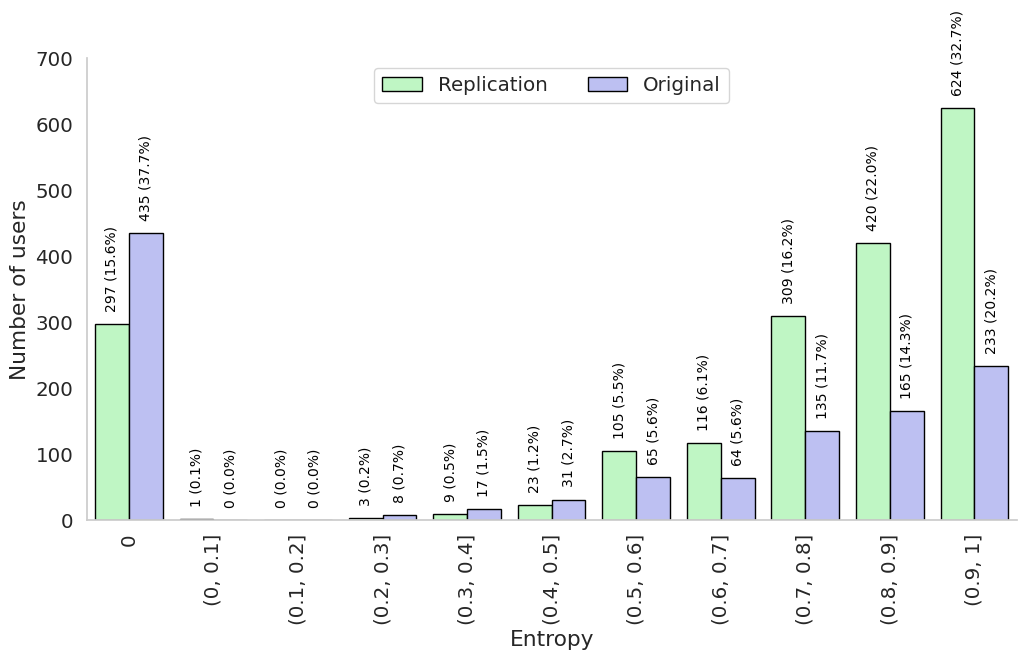

In [105]:
# Create the bar plot
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='Entropy', y='Number of users', hue='Study', data=plot_data, palette=['#B6FFBC', '#B4B8FB'], edgecolor='black')

# # Add annotations
# for index, row in plot_data.iterrows():
#     bar_plot.text(index, row['Number of users'] + 5, f"{row['Number of users']} ({row['Percentage']:.1f}%)", color='black', ha="center", fontsize=11)

# Annotate the boxes with the value and percentage
# for i,p in enumerate(ax.patches):
#     display(f"i: {i}, p: {p}")
#     # height = p.get_height()
#     # if height == 0:
#     #     continue
#     # t = 'Original' if i < 6 else 'Users'
#     # total = df_cwe_per_user_count[df_cwe_per_user_count['Type'] == t]['Count'].sum()
#     # percentage = height / total * 100
#     # ax.annotate(f'{int(height):,}\n({percentage:.1f}%)',
#     #             (p.get_x() + p.get_width() / 2., height+100),
#     #             ha='center', va='center',
#     #             xytext=(0, 9),
#     #             textcoords='offset points',
#     #             fontsize=10, color='black')

# Annotate the bars with the value and percentage
for i, p in enumerate(bar_plot.patches):
    height = p.get_height()
    if i >21:
        continue
    study = 'Replication' if i < 11 else 'Original'
    total = plot_data[plot_data['Study'] == study]['Number of users'].sum()
    percentage = height / total * 100
    bar_plot.annotate(f'{int(height):,} ({percentage:.1f}%)',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=10, color='black',rotation=90)

# Set plot labels and title
plt.xlabel('Entropy')
plt.ylabel('Number of users')
plt.grid(axis='y')
sns.despine()

# Rotate x-axis labels
plt.xticks(rotation=90)

# Legend top middle position
plt.legend(title=None, loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2)

plt.gca().set_ylim([0, 700])


# Save the plot
plt.savefig('plots/Zhang_RQ3_Entropy.pdf', bbox_inches='tight')
plt.show()

In [106]:
# Chi-square test of independence for the entropy distribution between the original and replication study
# Create contingency table for the chi-square test of independence
# Remove rows with 0 users
contingency_table = plot_data[plot_data['Number of users'] != 0].pivot(index='Entropy', columns='Study', values='Number of users')
contingency_table = contingency_table.dropna()
total_sample_size = contingency_table.values.sum()
display(contingency_table)

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print results
print("\nChi-Square Test Results:")
print(f"Chi2: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

# Interpret the p-value
if p < 0.05:
    print("There is a statistically significant difference between the distributions.")
    print(f"Chi-square({dof}, N={total_sample_size}) = {chi2}, p = {p}")
else:
    print("There is no statistically significant difference between the distributions.")

Study,Original,Replication
Entropy,,
"(0.2, 0.3]",8.0,3.0
"(0.3, 0.4]",17.0,9.0
"(0.4, 0.5]",31.0,23.0
"(0.5, 0.6]",65.0,105.0
"(0.6, 0.7]",64.0,116.0
"(0.7, 0.8]",135.0,309.0
"(0.8, 0.9]",165.0,420.0
"(0.9, 1]",233.0,624.0
0,435.0,297.0



Chi-Square Test Results:
Chi2: 243.50087038604835
P-value: 4.106413010663862e-48
Degrees of Freedom: 8
Expected Frequencies:
[[  4.14612619   6.85387381]
 [  9.79993462  16.20006538]
 [ 20.35371036  33.64628964]
 [ 64.07649559 105.92350441]
 [ 67.84570121 112.15429879]
 [167.35272965 276.64727035]
 [220.49852893 364.50147107]
 [323.02092187 533.97907813]
 [275.90585159 456.09414841]]
There is a statistically significant difference between the distributions.
Chi-square(8, N=3059.0) = 243.50087038604835, p = 4.106413010663862e-48


In [107]:
# Calculate Cramer's V
n = contingency_table.sum().sum()
phi2 = chi2 / n
r, k = contingency_table.shape
phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
rcorr = r - ((r-1)**2)/(n-1)
kcorr = k - ((k-1)**2)/(n-1)
cramer_v = np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

print(f"Cramer's V: {cramer_v}")

Cramer's V: 0.27750775799784283


> [one user](https://stackoverﬂow.com/users/3422102/) has contributed CWE-775, i.e., missing release of ﬁle descriptor or handle after effective lifetime, for 79 times.

UserId: 3422102 

In [119]:
example_user = df_user_cwe.loc[(df_user_cwe['UserId'] == 3422102) & (df_user_cwe['Num_CWE'] > 0), ['RootPostBlockVersionId', 'PostBlockVersionId', 'CWE', 'Num_CWE', 'CWE_Instances_Added', 'Num_CWE_Instances_Added']]
example_user.sort_values(by=['RootPostBlockVersionId', 'PostBlockVersionId'], ascending=False)

,RootPostBlockVersionId,PostBlockVersionId,CWE,Num_CWE,CWE_Instances_Added,Num_CWE_Instances_Added
494504,275401179,275401179,[457],1,[457],1
494417,275382054,275382054,"[775, 775]",2,"[775, 775]",2
493311,275079871,275079871,[685],1,[685],1
492730,274912761,274912761,[457],1,[457],1
492419,274821521,274821521,[775],1,[775],1
...,...,...,...,...,...,...
13419,142068864,142068864,[775],1,[775],1
11883,141620187,141620252,[775],1,[],0
11882,141620187,141620187,[775],1,[775],1
10087,141119766,141119766,[775],1,[775],1


In [110]:
example_user['Num_CWE'].sum()

362

In [111]:
example_user['Num_CWE_Instances_Added'].sum()

274

In [112]:
example_user['CWE'].explode().value_counts()

CWE
401    117
775    104
457     76
788     18
476     13
687     11
758      9
771      3
190      2
562      2
685      2
772      2
570      1
590      1
628      1
Name: count, dtype: int64

In [113]:
example_user['CWE_Instances_Added'].explode().value_counts()

CWE_Instances_Added
401    86
775    73
457    64
788    15
476    11
687     7
758     6
771     3
562     2
685     2
570     1
190     1
590     1
772     1
628     1
Name: count, dtype: int64

In [120]:
example_user_exploded  = example_user[['RootPostBlockVersionId', 'PostBlockVersionId', 'CWE', 'CWE_Instances_Added', 'Num_CWE_Instances_Added']].explode('CWE')
example_user_exploded = example_user_exploded[example_user_exploded['CWE'] == 775]
example_user_exploded = example_user_exploded.drop_duplicates(subset=['RootPostBlockVersionId', 'PostBlockVersionId', 'CWE'])
example_user_exploded['CWE-775-Added'] = example_user_exploded['CWE_Instances_Added'].apply(lambda x: 1 if 775 in x else 0)
example_user_exploded['CWE-775-Added'].value_counts()

CWE-775-Added
1    59
0    28
Name: count, dtype: int64

In [121]:
example_user_exploded[example_user_exploded['CWE-775-Added'] == 0]

,RootPostBlockVersionId,PostBlockVersionId,CWE,CWE_Instances_Added,Num_CWE_Instances_Added,CWE-775-Added
11883,141620187,141620252,775,[],0,0
36703,148516344,148516363,775,[],0,0
36704,148516344,148516385,775,[],0,0
38357,148995768,148995802,775,[],0,0
38358,148995768,148995854,775,[],0,0
38359,148995768,148995904,775,[],0,0
196380,192871863,192871878,775,[],0,0
205232,195479359,195479366,775,[],0,0
205233,195479359,195479372,775,[],0,0
249631,208172279,208172298,775,[],0,0
